In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import plotly.graph_objects as go
from plotly.subplots import make_subplots

!pip install yfinance
# Importing Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
def stock_data(stock, start_date, end_date):
    tickerSymbol = stock
    tickerData = yf.Ticker(tickerSymbol)
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)
    return tickerDf

df = stock_data("AAPL", "2014-06-08", "2025-06-08")
df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-06-09 00:00:00-04:00,20.430444,20.690508,20.221071,20.650837,301660000,0.0,7.0
2014-06-10 00:00:00-04:00,20.877840,20.948366,20.622183,20.772051,251108000,0.0,0.0
2014-06-11 00:00:00-04:00,20.745600,20.884448,20.600141,20.686094,182724000,0.0,0.0
2014-06-12 00:00:00-04:00,20.725764,20.743396,20.254123,20.340076,218996000,0.0,0.0
2014-06-13 00:00:00-04:00,20.320239,20.373134,20.029320,20.117477,218100000,0.0,0.0


In [4]:
df.shape

(2716, 7)

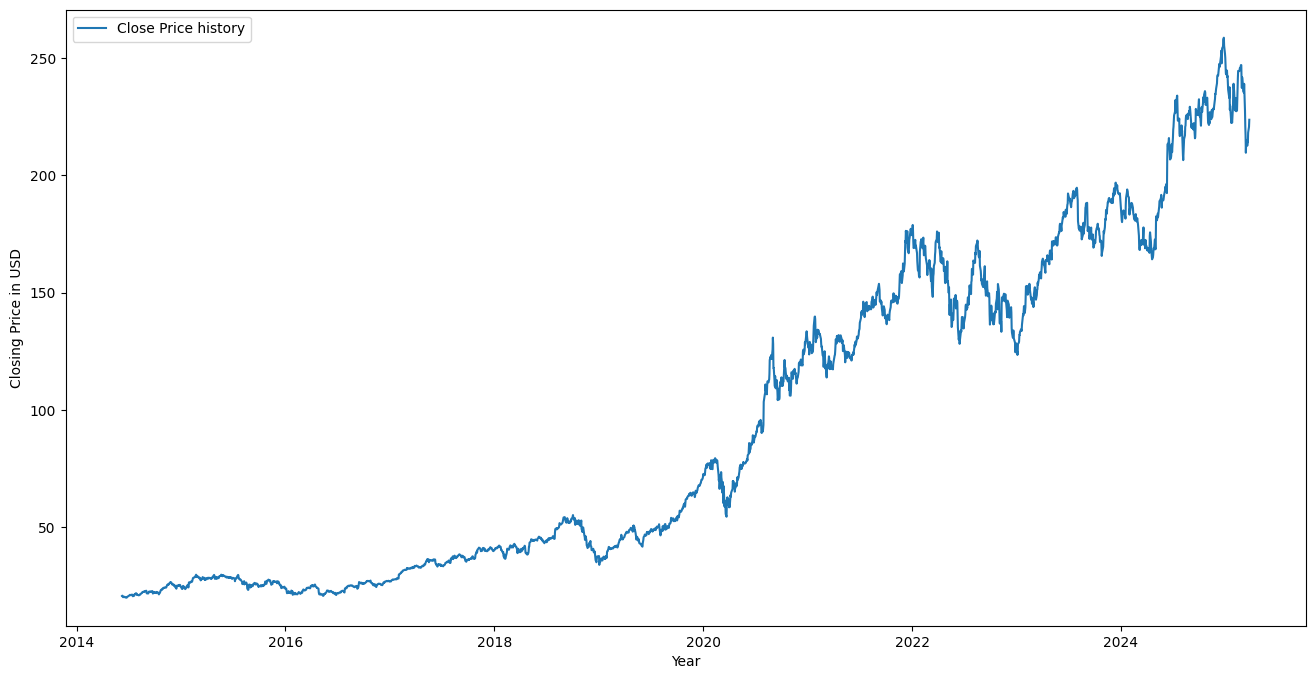

In [5]:
fig = plt.figure(figsize=(16,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.plot(df['Close'], label='Close Price history')
plt.legend()
plt.show()

In [6]:
df.dtypes
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2716.000000,2716.000000,2716.000000,2716.000000,2.716000e+03,2716.000000,2716.000000
mean,93.152692,94.148699,92.220098,93.234498,1.206845e+08,0.003002,0.004050
std,68.194729,68.914826,67.527752,68.268687,7.243280e+07,0.024277,0.154676
min,19.881657,19.989650,19.758238,19.897087,2.323470e+07,0.000000,0.000000
25%,31.453689,31.562279,31.307353,31.466461,7.111328e+07,0.000000,0.000000
50%,58.381760,59.351606,57.517352,58.641933,1.024612e+08,0.000000,0.000000
75%,150.922502,152.794844,149.363427,151.231449,1.494340e+08,0.000000,0.000000
max,257.906429,259.814335,257.347047,258.735504,7.593852e+08,0.250000,7.000000


In [7]:
df.reset_index(level="Date", inplace=True)
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [8]:
data = df.sort_index(ascending=True, axis=0)
df1 = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    df1["Date"][i] = data['Date'][i]
    df1["Close"][i] = data["Close"][i]

df1.index = df1.Date
df1.drop("Date", axis=1, inplace=True)
df1.head()

,Close
Date,
2014-06-09 00:00:00-04:00,20.650837
2014-06-10 00:00:00-04:00,20.772051
2014-06-11 00:00:00-04:00,20.686094
2014-06-12 00:00:00-04:00,20.340076
2014-06-13 00:00:00-04:00,20.117477


In [9]:
data = df1.values
train = data[0:1750, :]
test = data[1750:, :]

print(train.shape)
print(test.shape)

(1750, 1)
(966, 1)


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [11]:
x_train, y_train = [], []
window = 60

for i in range(window, len(train)):
    x_train.append(scaled_data[i-window:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
inputs = df1[len(df1) - len(test) - window:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(window, inputs.shape[0]):
    x_test.append(inputs[i-window:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(x_train, y_train, epochs=2, batch_size=64, verbose=2)

Epoch 1/2
27/27 - 5s - 191ms/step - loss: 0.0048
Epoch 2/2
27/27 - 4s - 152ms/step - loss: 2.4119e-04


In [15]:
closing_price = model.predict(x_test)
train_predict = model.predict(x_train)

closing_price = scaler.inverse_transform(closing_price)
train_predict = scaler.inverse_transform(train_predict)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [16]:
mse = math.sqrt(mean_squared_error(test, closing_price))
print(f"Root Mean Squared Error: {mse}")

Root Mean Squared Error: 7.463530819750346


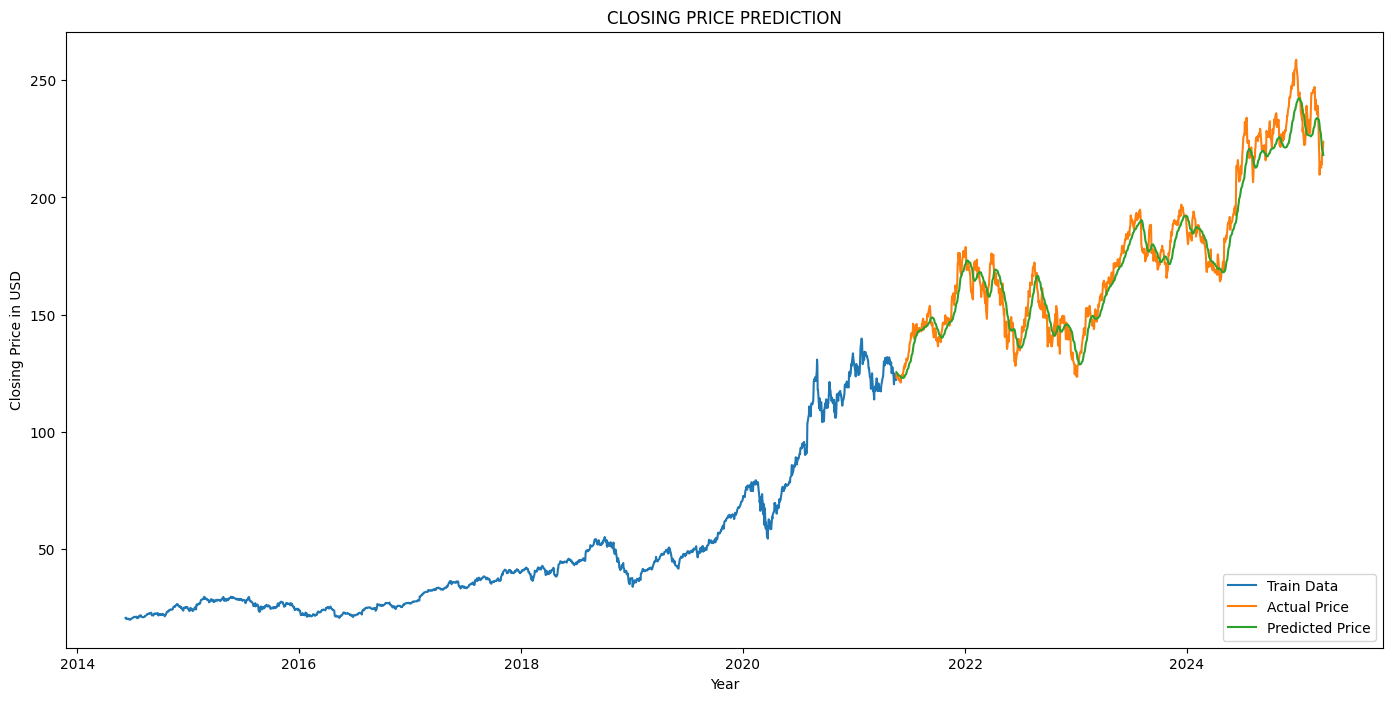

In [17]:
train = df1[:1750]
test = df1[1750:]
test['Predictions'] = closing_price

plt.figure(figsize=(17,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.title("CLOSING PRICE PREDICTION")
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(["Train Data", "Actual Price", "Predicted Price"], loc="lower right")
plt.show()

In [18]:
aapl = yf.download('AAPL', start = '2010-07-01', end = '2023-02-11')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [19]:
aapl

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-07-01,7.477656,7.667848,7.319364,7.652801,1022896000
2010-07-02,7.431314,7.551387,7.318762,7.538145,693842800
2010-07-06,7.482171,7.607660,7.407839,7.553492,615235600
2010-07-07,7.784312,7.787322,7.515878,7.538147,654556000
2010-07-08,7.766858,7.911609,7.670559,7.898969,738144400
...,...,...,...,...,...
2023-02-06,149.986115,151.340379,149.047036,150.816472,69858300
2023-02-07,152.872574,153.445910,148.908667,148.908667,83322600


In [20]:
aapl.dtypes

,,0
Price,Ticker,
Close,AAPL,float64
High,AAPL,float64
Low,AAPL,float64
Open,AAPL,float64
Volume,AAPL,int64


In [31]:

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05, row_heights = [0.7, 0.3])
fig.add_trace(go.Candlestick(x=aapl.index,
                             open=aapl[('Open', 'AAPL')],
                             high=aapl[('High', 'AAPL')],
                             low=aapl[('Low', 'AAPL')],
                             close=aapl[('Close', 'AAPL')],
                             name='AAPL'),
              row=1, col=1)


# Plotting volume chart on the second row
fig.add_trace(go.Bar(x=aapl.index,
                     y=aapl['Volume'],
                     name='Volume',
                     marker=dict(color='orange', opacity=1.0)),
              row=2, col=1)

# Plotting annotation
fig.add_annotation(text='Apple (AAPL)',
                    font=dict(color='white', size=40),
                    xref='paper', yref='paper',
                    x=0.5, y=0.65,
                    showarrow=False,
                    opacity=0.2)

# Configuring layout
fig.update_layout(title='AAPL Candlestick Chart From July 1st, 2010 to February 10th, 2023',
                  yaxis=dict(title='Price (USD)'),
                  height=1000,
                 template = 'plotly_dark')

# Configuring axes and subplots
fig.update_xaxes(rangeslider_visible=False, row=1, col=1)
fig.update_xaxes(rangeslider_visible=False, row=2, col=1)
fig.update_yaxes(title_text='Price (USD)', row=1, col=1)
fig.update_yaxes(title_text='Volume', row=2, col=1)

fig.show()


In [28]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [38]:
print(aapl.head())
print(aapl.info())


Price          Close      High       Low      Open      Volume      EMA9  \
Ticker          AAPL      AAPL      AAPL      AAPL        AAPL             
Date                                                                       
2010-07-01  7.477656  7.667848  7.319364  7.652801  1022896000  7.477656   
2010-07-02  7.431314  7.551387  7.318762  7.538145   693842800  7.468388   
2010-07-06  7.482171  7.607660  7.407839  7.553492   615235600  7.471144   
2010-07-07  7.784312  7.787322  7.515878  7.538147   654556000  7.533778   
2010-07-08  7.766858  7.911609  7.670559  7.898969   738144400  7.580394   

Price      SMA20 SMA50 SMA100 SMA200 RSI BB_UPPER BB_LOWER  
Ticker                                                      
Date                                                        
2010-07-01   NaN   NaN    NaN    NaN NaN      NaN      NaN  
2010-07-02   NaN   NaN    NaN    NaN NaN      NaN      NaN  
2010-07-06   NaN   NaN    NaN    NaN NaN      NaN      NaN  
2010-07-07   NaN   NaN   

In [39]:
# Adding Moving Averages
aapl['EMA9'] = aapl[('Close', 'AAPL')].ewm(span=9, adjust=False).mean()  # Exponential 9-Period Moving Average
aapl['SMA20'] = aapl[('Close', 'AAPL')].rolling(window=20).mean()  # Simple 20-Period Moving Average
aapl['SMA50'] = aapl[('Close', 'AAPL')].rolling(window=50).mean()  # Simple 50-Period Moving Average
aapl['SMA100'] = aapl[('Close', 'AAPL')].rolling(window=100).mean()  # Simple 100-Period Moving Average
aapl['SMA200'] = aapl[('Close', 'AAPL')].rolling(window=200).mean()  # Simple 200-Period Moving Average

# Adding RSI for 14-periods
delta = aapl[('Close', 'AAPL')].diff()  # Calculating delta
gain = delta.where(delta > 0, 0)  # Obtaining gain values
loss = -delta.where(delta < 0, 0)  # Obtaining loss values
avg_gain = gain.rolling(window=14).mean()  # Measuring the 14-period average gain value
avg_loss = loss.rolling(window=14).mean()  # Measuring the 14-period average loss value
rs = avg_gain / avg_loss  # Calculating the RS
aapl['RSI'] = 100 - (100 / (1 + rs))  # Creating an RSI column in the DataFrame

# Adding Bollinger Bands for 20-periods
aapl['BB_UPPER'] = aapl['SMA20'] + 2 * aapl[('Close', 'AAPL')].rolling(window=20).std()  # Upper Band
aapl['BB_LOWER'] = aapl['SMA20'] - 2 * aapl[('Close', 'AAPL')].rolling(window=20).std()  # Lower Band


In [40]:
aapl.tail(50)

Price,Close,High,Low,Open,Volume,EMA9,SMA20,SMA50,SMA100,SMA200,RSI,BB_UPPER,BB_LOWER
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,
Date,,,,,,,,,,,,,
2022-11-30,146.328659,147.010731,138.934632,139.774854,111380900,145.160573,143.906299,144.128152,150.908606,152.018094,64.667862,154.074184,133.738414
2022-12-01,146.605423,147.416006,144.924965,146.506581,71250400,145.449543,144.080286,144.026229,150.937209,151.900947,52.172599,154.310823,133.849749
2022-12-02,146.111160,146.298979,143.975982,144.282432,65447400,145.581866,144.533021,143.933763,150.964516,151.782509,46.932798,154.242965,134.823076
2022-12-05,144.944748,149.185435,144.094632,146.071645,68826400,145.454443,144.940781,143.863562,150.950790,151.676297,47.301311,153.940514,135.941047
2022-12-06,141.267487,145.607030,140.288860,145.379678,64727200,144.617052,145.137988,143.713105,150.883539,151.559472,39.040876,153.591165,136.684811
2022-12-07,139.320145,141.722209,138.390946,140.555778,69721100,143.557670,145.209161,143.504161,150.827365,151.447574,38.195489,153.426300,136.992023
2022-12-08,141.010468,141.870479,139.478294,140.723807,62128300,143.048230,145.593689,143.366920,150.749363,151.365038,37.783780,151.985198,139.202180
2022-12-09,140.526108,143.896919,139.280580,140.704032,76097000,142.543805,145.360896,143.365259,150.646414,151.266943,36.145664,152.142777,138.579014


In [41]:
fig.add_trace(go.Scatter(x=aapl.index,
                         y=aapl['EMA9'],
                         mode='lines',
                         name='EMA9'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=aapl.index,
                         y=aapl['SMA20'],
                         mode='lines',
                         name='SMA20'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=aapl.index,
                         y=aapl['BB_UPPER'],
                         mode='lines',
                         name='Bollinger Upper'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=aapl.index,
                         y=aapl['BB_LOWER'],
                         mode='lines',
                         name='Bollinger Lower'),
              row=1, col=1)
